<a href="https://colab.research.google.com/github/Firespiko/Firespiko/blob/main/GST_854_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Training Notebook***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


***Importing Necessary Libraries***

In [ ]:
import pandas as pd
import numpy as np

# Data preprocessing and model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve)
from sklearn.linear_model import LogisticRegression

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Hyperparameter tuning
import optuna

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


***Load and Prepare the Dataset***

In [ ]:
# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/original/FullDataset_final_v0.csv')  # Uncomment if loading from a CSV file

df = df.drop(columns = ['ID'])


In [ ]:
df.fillna(0, inplace=True)

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

***Train-Test Split***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

***Handle Class Imbalance with SMOTE***

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


***Feature Scaling***

In [ ]:
scaler = StandardScaler()
columns_to_scale = ['Column5', 'Column14','Column15' ]

# Fit the scaler on the training data
X_train_resampled[columns_to_scale] = scaler.fit_transform(
    X_train_resampled[columns_to_scale]
)

# Transform the test data
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


***Generate 2nd-Degree Polynomial Features***

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform the training data
X_train_poly = poly.fit_transform(X_train_resampled)

# Transform the test data
X_test_poly = poly.transform(X_test)

***Hyperparameter Tuning with Optuna***

In [ ]:
def objective(trial):
    # Suggest hyperparameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    solver = 'saga' if penalty == 'elasticnet' else 'liblinear' if penalty == 'l1' else 'lbfgs'

    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
        model = LogisticRegression(
            penalty=penalty, C=C, solver=solver, l1_ratio=l1_ratio, max_iter=1000
        )
    else:
        model = LogisticRegression(
            penalty=penalty, C=C, solver=solver, max_iter=1000
        )

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, X_train_poly, y_train_resampled, cv=cv, scoring='f1', n_jobs=-1
    )

    return scores.mean()

# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=)

print('Best hyperparameters:', study.best_params)


[I 2024-10-12 05:09:43,624] A new study created in memory with name: no-name-7fa2b738-a8d3-4de1-b630-d4f5bf15425a
[I 2024-10-12 05:09:55,688] Trial 0 finished with value: 0.9810337596265079 and parameters: {'penalty': 'l2', 'C': 29.415361143107354}. Best is trial 0 with value: 0.9810337596265079.
[I 2024-10-12 05:10:28,407] Trial 1 finished with value: 0.9810465171327414 and parameters: {'penalty': 'l1', 'C': 0.10403259441747038}. Best is trial 1 with value: 0.9810465171327414.
[I 2024-10-12 05:11:27,388] Trial 2 finished with value: 0.9810323043647353 and parameters: {'penalty': 'l1', 'C': 0.050806988460853644}. Best is trial 1 with value: 0.9810465171327414.
[I 2024-10-12 05:11:58,708] Trial 3 finished with value: 0.9810661554670294 and parameters: {'penalty': 'l1', 'C': 2.9591690199334986}. Best is trial 3 with value: 0.9810661554670294.
[I 2024-10-12 05:12:09,943] Trial 4 finished with value: 0.9810468972409737 and parameters: {'penalty': 'l2', 'C': 2.696139810291814}. Best is tria

Best hyperparameters: {'penalty': 'l1', 'C': 9.967205777924498}


***Train the Final Model***

In [ ]:
best_params = study.best_params
penalty = best_params['penalty']
C = best_params['C']
solver = 'saga' if penalty == 'elasticnet' else 'liblinear' if penalty == 'l1' else 'lbfgs'

if penalty == 'elasticnet':
    l1_ratio = best_params['l1_ratio']
    model = LogisticRegression(
        penalty=penalty, C=C, solver=solver, l1_ratio=l1_ratio, max_iter=1000
    )
else:
    model = LogisticRegression(
        penalty=penalty, C=C, solver=solver, max_iter=1000
    )

# Fit the model on the training data
model.fit(X_train_poly, y_train_resampled)


LogisticRegression(C=9.967205777924498, max_iter=1000, penalty='l1',
                   solver='liblinear')

***Model Evaluation***

**___________________________________________________________________________**

***Predictions and Probabilities***

In [ ]:
# Predict probabilities
y_pred_prob = model.predict_proba(X_test_poly)[:, 1]

# Predict classes
y_pred = model.predict(X_test_poly)


***Evaluation Metrics***

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)


***Display Evaluation Metrics***

In [ ]:
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')
print('\nConfusion Matrix:')
print(conf_matrix)


Accuracy: 0.9660
Precision: 0.7356
Recall: 0.9979
F1 Score: 0.8469
AUC-ROC: 0.9898

Confusion Matrix:
[[182545   7082]
 [    42  19700]]


***Classification Report***

***ROC Curve***

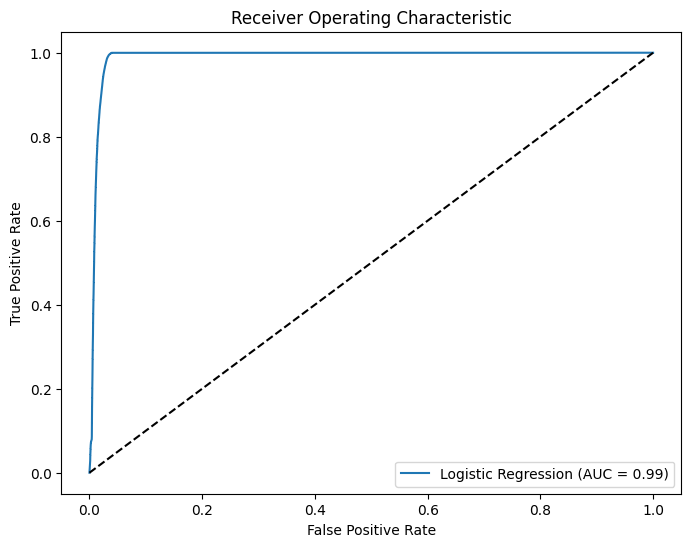

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


***Confidence Scores***

In [ ]:
# Display confidence scores for the first 10 predictions
confidence_scores = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred,
    'Confidence Score': y_pred_prob
})

print('\nConfidence Scores (first 10 predictions):')
print(confidence_scores.head(10))



Confidence Scores (first 10 predictions):
   Actual  Predicted  Confidence Score
0       0          0          0.009892
1       0          0          0.000648
2       0          0          0.018345
3       0          0          0.005392
4       0          0          0.008400
5       0          0          0.087965
6       0          0          0.005129
7       0          0          0.004260
8       0          0          0.011504
9       0          0          0.005120


***Feature Importance***

In [ ]:
# Get feature names
feature_names = poly.get_feature_names_out(input_features=X_train_resampled.columns)

# Get coefficients
coefficients = model.coef_[0]

# Create a DataFrame with feature importances
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Calculate the absolute value of coefficients
coef_df['Abs Coefficient'] = coef_df['Coefficient'].abs()

# Sort the features by absolute coefficient
top_features = coef_df.sort_values(by='Abs Coefficient', ascending=False).head(10)

print('\nTop 10 Important Features:')
print(top_features[['Feature', 'Coefficient']])



Top 10 Important Features:
                        Feature  Coefficient
12                     Column18     7.297774
25              Column5_outlier    -3.472376
20         Column14_upper_bound    -2.838820
2                       Column7    -2.796107
21         Column14_lower_bound    -2.303020
24              Column5_missing    -2.050103
39              Column6_missing    -2.007277
43  upper_bound_indicator_Colm7     1.987529
16             Column14_missing    -1.631797
42      outlier_indicator_Colm7    -1.540503


In [ ]:
from sklearn.metrics import log_loss

# Calculate Balanced Accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_prob)

# Print the scores
print(f'Balanced Accuracy: {balanced_accuracy:.4f}')
print(f'Log Loss: {logloss:.4f}')


Balanced Accuracy: 0.9803
Log Loss: 0.1348
